In [ ]:
!pip install torch torchvision torchaudio --quiet

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/CricVision/final_dataset.csv")

# Encode phase IDs
encoder = LabelEncoder()
df["phase_encoded"] = encoder.fit_transform(df["phase_id"])

# Normalize frame_number and phase_encoded
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(df[["frame_number", "phase_encoded"]])
X = X.astype(np.float32)

# Normalize scores (targets)
score_cols = [c for c in df.columns if "score" in c]
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(df[score_cols])
y = y.astype(np.float32)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (23912, 2) Val: (5124, 2) Test: (5124, 2)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class PoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 256
train_loader = DataLoader(PoseDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(PoseDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(PoseDataset(X_test, y_test), batch_size=batch_size)


In [ ]:
import torch.nn as nn

class PoseRegressor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=2, output_dim=5, dropout=0.2):
        super(PoseRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, seq_len=1, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

model = PoseRegressor()
print(model)


PoseRegressor(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.amp.GradScaler("cuda")  # updated mixed precision

epochs = 30
best_val_loss = float('inf')


In [ ]:
from tqdm.auto import tqdm

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda"):
            preds = model(Xb)
            loss = criterion(preds, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item() * Xb.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * Xb.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/CricVision/best_pose_model.pth")
        print("Model saved.")


Epoch 1/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.3802 | Val Loss: 0.2497
Model saved.


Epoch 2/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 0.1219 | Val Loss: 0.0785
Model saved.


Epoch 3/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.0823 | Val Loss: 0.0775
Model saved.


Epoch 4/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.0812 | Val Loss: 0.0766
Model saved.


Epoch 5/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.0802 | Val Loss: 0.0761
Model saved.


Epoch 6/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.0796 | Val Loss: 0.0753
Model saved.


Epoch 7/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.0790 | Val Loss: 0.0750
Model saved.


Epoch 8/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.0786 | Val Loss: 0.0749
Model saved.


Epoch 9/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 0.0783 | Val Loss: 0.0748
Model saved.


Epoch 10/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.0785 | Val Loss: 0.0748


Epoch 11/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.0784 | Val Loss: 0.0749


Epoch 12/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.0784 | Val Loss: 0.0748


Epoch 13/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.0782 | Val Loss: 0.0748


Epoch 14/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.0783 | Val Loss: 0.0747
Model saved.


Epoch 15/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.0779 | Val Loss: 0.0746
Model saved.


Epoch 16/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.0781 | Val Loss: 0.0748


Epoch 17/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.0781 | Val Loss: 0.0746
Model saved.


Epoch 18/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.0779 | Val Loss: 0.0747


Epoch 19/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.0779 | Val Loss: 0.0747


Epoch 20/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.0778 | Val Loss: 0.0747


Epoch 21/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.0777 | Val Loss: 0.0746
Model saved.


Epoch 22/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.0779 | Val Loss: 0.0746


Epoch 23/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.0778 | Val Loss: 0.0748


Epoch 24/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.0775 | Val Loss: 0.0750


Epoch 25/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.0778 | Val Loss: 0.0746
Model saved.


Epoch 26/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 0.0774 | Val Loss: 0.0747


Epoch 27/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 0.0776 | Val Loss: 0.0747


Epoch 28/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 0.0776 | Val Loss: 0.0751


Epoch 29/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 0.0778 | Val Loss: 0.0748


Epoch 30/30:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.0777 | Val Loss: 0.0747


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CricVision/best_pose_model.pth"))
model.eval()

preds_all, y_all = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        preds_all.append(preds.cpu().numpy())
        y_all.append(yb.numpy())

import numpy as np
preds_all = np.vstack(preds_all)
y_all = np.vstack(y_all)

mae = np.mean(np.abs(preds_all - y_all))
rmse = np.sqrt(np.mean((preds_all - y_all)**2))
print(f"Test MAE: {mae:.4f} | RMSE: {rmse:.4f}")


Test MAE: 0.2378 | RMSE: 0.2780


In [ ]:
import os, shutil

# Parent folder where frames are being copied
root_folder = "/content/drive/MyDrive/CricVision/All_Frames"
dst_folder = "/content/drive/MyDrive/CricVision/sample_frames"

# How many total frames you want
num_frames_needed = 10
os.makedirs(dst_folder, exist_ok=True)

copied = 0
for phase_folder in sorted(os.listdir(root_folder)):
    phase_path = os.path.join(root_folder, phase_folder)
    if not os.path.isdir(phase_path):
        continue

    for img in sorted(os.listdir(phase_path)):
        if img.lower().endswith(".jpg"):
            shutil.copy(os.path.join(phase_path, img),
                        os.path.join(dst_folder, f"{phase_folder}_{img}"))
            copied += 1
        if copied >= num_frames_needed:
            break
    if copied >= num_frames_needed:
        break

print(f"Copied {copied} frames from multiple phase folders to {dst_folder}")
print("Folder ready for YOLOv8-Pose extraction.")


Copied 10 frames from multiple phase folders to /content/drive/MyDrive/CricVision/sample_frames
Folder ready for YOLOv8-Pose extraction.


In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2

# Path to the folder with your 10 frames
image_folder = "/content/drive/MyDrive/CricVision/sample_frames"
output_csv   = "/content/drive/MyDrive/CricVision/keypoints_sample.csv"

# Load pretrained YOLOv8-Pose model
model = YOLO("yolov8s-pose.pt")

records = []

for img_name in sorted(os.listdir(image_folder)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue
    img_path = os.path.join(image_folder, img_name)
    results = model(img_path, verbose=False)

    for r in results:
        if r.keypoints is None:
            continue
        keypoints = r.keypoints.data.cpu().numpy()  # shape: (n_dets, 17, 3)
        if keypoints.shape[0] == 0:
            continue
        kp = keypoints[0]  # take the first detection
        records.append([img_name] + kp.flatten().tolist())

columns = ["frame_name"] + [f"kpt_{i}_{axis}" for i in range(17) for axis in ["x", "y", "conf"]]
df = pd.DataFrame(records, columns=columns)
df.to_csv(output_csv, index=False)

print(f"Extracted keypoints for {len(df)} frames.")
print("Saved to:", output_csv)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Extracted keypoints for 10 frames.
Saved to: /content/drive/MyDrive/CricVision/keypoints_sample.csv


In [ ]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import pandas as pd
import os
import torch
from tqdm import tqdm

# --- GPU optimizations (helps even a bit on L4/T4) ---
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True
torch.set_float32_matmul_precision('high')

# --- Paths ---
root_folder = "/content/drive/MyDrive/CricVision/All_Frames"   # where your dataset is
output_folder = "/content/drive/MyDrive/CricVision/Pose_Keypoints"
os.makedirs(output_folder, exist_ok=True)

# --- Model ---
model = YOLO("yolov8s-pose.pt")  # 's' model: lightweight and reliable for long runs

# --- Parameters ---
batch_size = 500   # save a CSV every 500 frames
folders = sorted(os.listdir(root_folder))
print(f"Total phase folders: {len(folders)}")

records = []
processed = 0
batch_idx = 1

# --- Main Loop ---
for phase_folder in tqdm(folders, desc="Processing folders"):
    phase_path = os.path.join(root_folder, phase_folder)
    if not os.path.isdir(phase_path):
        continue

    images = sorted([f for f in os.listdir(phase_path) if f.lower().endswith((".jpg", ".png"))])
    if len(images) == 0:
        continue

    for img_name in images:
        img_path = os.path.join(phase_path, img_name)
        results = model(img_path, verbose=False)

        for r in results:
            if r.keypoints is None:
                continue
            keypoints = r.keypoints.data.cpu().numpy()
            if keypoints.shape[0] == 0:
                continue
            kp = keypoints[0]
            records.append([f"{phase_folder}_{img_name}"] + kp.flatten().tolist())
            processed += 1

        # Save partial results every 500 frames
        if processed % batch_size == 0:
            df = pd.DataFrame(
                records,
                columns=["frame_name"] + [f"kpt_{i}_{axis}" for i in range(17) for axis in ["x", "y", "conf"]],
            )
            save_path = os.path.join(output_folder, f"pose_keypoints_batch_{batch_idx}.csv")
            df.to_csv(save_path, index=False)
            print(f"Saved batch {batch_idx} ({processed} frames processed).")
            records.clear()
            batch_idx += 1

# --- Save remaining records ---
if records:
    df = pd.DataFrame(
        records,
        columns=["frame_name"] + [f"kpt_{i}_{axis}" for i in range(17) for axis in ["x", "y", "conf"]],
    )
    save_path = os.path.join(output_folder, f"pose_keypoints_batch_{batch_idx}.csv")
    df.to_csv(save_path, index=False)
    print(f"Saved final batch {batch_idx} ({processed} frames processed).")

print(f"\n✅ Extraction complete. Total frames processed: {processed}")
print("All CSVs saved in:", output_folder)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Total phase folders: 8540


Processing folders:   2%|▏         | 131/8540 [06:18<6:32:24,  2.80s/it]

Saved batch 1 (500 frames processed).


Processing folders:   3%|▎         | 262/8540 [12:15<6:34:37,  2.86s/it]

Saved batch 2 (1000 frames processed).


Processing folders:   5%|▍         | 399/8540 [18:30<6:19:14,  2.80s/it]

Saved batch 3 (1500 frames processed).


Processing folders:   6%|▌         | 526/8540 [24:22<6:15:15,  2.81s/it]

Saved batch 4 (2000 frames processed).


Processing folders:   8%|▊         | 654/8540 [30:01<5:58:25,  2.73s/it]

Saved batch 5 (2500 frames processed).


Processing folders:   9%|▉         | 784/8540 [35:53<5:47:16,  2.69s/it]

Saved batch 6 (3000 frames processed).


Processing folders:  11%|█         | 924/8540 [42:11<5:50:25,  2.76s/it]

Saved batch 7 (3500 frames processed).


Processing folders:  12%|█▏        | 1050/8540 [48:21<6:17:37,  3.03s/it]

Saved batch 8 (4000 frames processed).


Processing folders:  14%|█▍        | 1182/8540 [55:08<6:26:42,  3.15s/it]

Saved batch 9 (4500 frames processed).


Processing folders:  15%|█▌        | 1311/8540 [1:01:52<6:01:56,  3.00s/it]

Saved batch 10 (5000 frames processed).


Processing folders:  17%|█▋        | 1449/8540 [1:08:54<5:59:08,  3.04s/it]

Saved batch 11 (5500 frames processed).


Processing folders:  19%|█▊        | 1586/8540 [1:15:54<6:05:33,  3.15s/it]

Saved batch 12 (6000 frames processed).


Processing folders:  20%|██        | 1715/8540 [1:22:36<5:55:08,  3.12s/it]

Saved batch 13 (6500 frames processed).


Processing folders:  22%|██▏       | 1844/8540 [1:29:18<5:47:46,  3.12s/it]

Saved batch 14 (7000 frames processed).


Processing folders:  23%|██▎       | 1972/8540 [1:36:00<5:21:54,  2.94s/it]

Saved batch 15 (7500 frames processed).


Processing folders:  25%|██▍       | 2099/8540 [1:42:40<5:37:40,  3.15s/it]

Saved batch 16 (8000 frames processed).


Processing folders:  26%|██▌       | 2227/8540 [1:49:25<5:32:14,  3.16s/it]

Saved batch 17 (8500 frames processed).


Processing folders:  28%|██▊       | 2354/8540 [1:56:06<5:24:03,  3.14s/it]

Saved batch 18 (9000 frames processed).


Processing folders:  29%|██▉       | 2494/8540 [2:03:33<5:26:53,  3.24s/it]

Saved batch 19 (9500 frames processed).


Processing folders:  31%|███       | 2628/8540 [2:10:36<5:02:45,  3.07s/it]

Saved batch 20 (10000 frames processed).


Processing folders:  32%|███▏      | 2758/8540 [2:17:28<5:07:35,  3.19s/it]

Saved batch 21 (10500 frames processed).


Processing folders:  34%|███▍      | 2889/8540 [2:24:31<4:48:14,  3.06s/it]

Saved batch 22 (11000 frames processed).


Processing folders:  35%|███▌      | 3019/8540 [2:31:25<4:56:02,  3.22s/it]

Saved batch 23 (11500 frames processed).


Processing folders:  37%|███▋      | 3156/8540 [2:38:56<4:59:34,  3.34s/it]

Saved batch 24 (12000 frames processed).


Processing folders:  39%|███▊      | 3290/8540 [2:46:33<5:02:19,  3.46s/it]

Saved batch 25 (12500 frames processed).


Processing folders:  41%|████      | 3463/8540 [2:56:28<4:39:25,  3.30s/it]

Saved batch 26 (13000 frames processed).


Processing folders:  42%|████▏     | 3594/8540 [3:04:12<5:57:47,  4.34s/it]

Saved batch 27 (13500 frames processed).


Processing folders:  44%|████▎     | 3724/8540 [3:11:36<3:53:57,  2.91s/it]

Saved batch 28 (14000 frames processed).


Processing folders:  45%|████▌     | 3853/8540 [3:19:04<4:54:12,  3.77s/it]

Saved batch 29 (14500 frames processed).


Processing folders:  47%|████▋     | 3984/8540 [3:26:00<3:28:09,  2.74s/it]

Saved batch 30 (15000 frames processed).


Processing folders:  48%|████▊     | 4118/8540 [3:33:05<4:00:30,  3.26s/it]

Saved batch 31 (15500 frames processed).


Processing folders:  50%|████▉     | 4250/8540 [3:40:53<3:41:17,  3.10s/it]

Saved batch 32 (16000 frames processed).


Processing folders:  51%|█████▏    | 4378/8540 [3:48:17<3:52:18,  3.35s/it]

Saved batch 33 (16500 frames processed).


Processing folders:  53%|█████▎    | 4507/8540 [3:55:09<3:37:01,  3.23s/it]

Saved batch 34 (17000 frames processed).


Processing folders:  54%|█████▍    | 4633/8540 [4:02:14<3:43:02,  3.43s/it]

Saved batch 35 (17500 frames processed).


Processing folders:  56%|█████▌    | 4763/8540 [4:09:38<3:52:47,  3.70s/it]

Saved batch 36 (18000 frames processed).


Processing folders:  57%|█████▋    | 4891/8540 [4:17:16<3:31:10,  3.47s/it]

Saved batch 37 (18500 frames processed).


Processing folders:  59%|█████▉    | 5026/8540 [4:25:02<3:12:19,  3.28s/it]

Saved batch 38 (19000 frames processed).


Processing folders:  60%|██████    | 5157/8540 [4:32:39<3:26:39,  3.67s/it]

Saved batch 39 (19500 frames processed).


Processing folders:  62%|██████▏   | 5284/8540 [4:39:56<3:07:16,  3.45s/it]

Saved batch 40 (20000 frames processed).


Processing folders:  63%|██████▎   | 5411/8540 [4:47:18<3:01:47,  3.49s/it]

Saved batch 41 (20500 frames processed).


Processing folders:  65%|██████▍   | 5540/8540 [4:54:44<3:11:03,  3.82s/it]

Saved batch 42 (21000 frames processed).


Processing folders:  66%|██████▋   | 5667/8540 [5:02:04<2:28:54,  3.11s/it]

Saved batch 43 (21500 frames processed).


Processing folders:  68%|██████▊   | 5795/8540 [5:08:46<2:30:47,  3.30s/it]

Saved batch 44 (22000 frames processed).


Processing folders:  69%|██████▉   | 5922/8540 [5:15:51<2:23:49,  3.30s/it]

Saved batch 45 (22500 frames processed).


Processing folders:  71%|███████   | 6049/8540 [5:23:06<2:16:58,  3.30s/it]

Saved batch 46 (23000 frames processed).


Processing folders:  72%|███████▏  | 6174/8540 [5:30:25<2:10:54,  3.32s/it]

Saved batch 47 (23500 frames processed).


Processing folders:  74%|███████▍  | 6301/8540 [5:37:36<2:10:41,  3.50s/it]

Saved batch 48 (24000 frames processed).


Processing folders:  75%|███████▌  | 6430/8540 [5:44:55<1:54:18,  3.25s/it]

Saved batch 49 (24500 frames processed).


Processing folders:  77%|███████▋  | 6557/8540 [5:52:01<1:49:09,  3.30s/it]

Saved batch 50 (25000 frames processed).


Processing folders:  78%|███████▊  | 6683/8540 [5:59:19<1:48:49,  3.52s/it]

Saved batch 51 (25500 frames processed).


Processing folders:  80%|███████▉  | 6811/8540 [6:06:19<1:41:19,  3.52s/it]

Saved batch 52 (26000 frames processed).


Processing folders:  81%|████████  | 6937/8540 [6:13:22<1:28:43,  3.32s/it]

Saved batch 53 (26500 frames processed).


Processing folders:  83%|████████▎ | 7068/8540 [6:21:05<1:28:42,  3.62s/it]

Saved batch 54 (27000 frames processed).


Processing folders:  84%|████████▍ | 7198/8540 [6:28:24<1:16:57,  3.44s/it]

Saved batch 55 (27500 frames processed).


Processing folders:  86%|████████▌ | 7327/8540 [6:35:38<1:15:51,  3.75s/it]

Saved batch 56 (28000 frames processed).


Processing folders:  87%|████████▋ | 7454/8540 [6:43:08<1:13:40,  4.07s/it]

Saved batch 57 (28500 frames processed).


Processing folders:  89%|████████▉ | 7584/8540 [6:50:20<49:23,  3.10s/it]

Saved batch 58 (29000 frames processed).


Processing folders:  90%|█████████ | 7716/8540 [6:57:46<45:33,  3.32s/it]

Saved batch 59 (29500 frames processed).


Processing folders:  92%|█████████▏| 7847/8540 [7:05:10<35:18,  3.06s/it]

Saved batch 60 (30000 frames processed).


Processing folders:  93%|█████████▎| 7981/8540 [7:12:13<30:11,  3.24s/it]

Saved batch 61 (30500 frames processed).


Processing folders:  95%|█████████▍| 8112/8540 [7:19:38<27:30,  3.86s/it]

Saved batch 62 (31000 frames processed).


Processing folders:  97%|█████████▋| 8260/8540 [7:27:58<16:17,  3.49s/it]

Saved batch 63 (31500 frames processed).


Processing folders:  98%|█████████▊| 8397/8540 [7:35:35<07:53,  3.31s/it]

Saved batch 64 (32000 frames processed).


Processing folders: 100%|██████████| 8540/8540 [7:43:28<00:00,  3.26s/it]

Saved final batch 65 (32492 frames processed).

✅ Extraction complete. Total frames processed: 32492
All CSVs saved in: /content/drive/MyDrive/CricVision/Pose_Keypoints


In [ ]:
import pandas as pd
import glob
import os

# Path to folder with all the batch CSVs
pose_folder = "/content/drive/MyDrive/CricVision/Pose_Keypoints"
output_csv = "/content/drive/MyDrive/CricVision/pose_keypoints_full.csv"

# Find all CSVs (sorted for consistent order)
csv_files = sorted(glob.glob(os.path.join(pose_folder, "pose_keypoints_batch_*.csv")))
print(f"Found {len(csv_files)} CSV files to merge.")

# Read and concatenate all CSVs
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)
    print(f"Merged: {os.path.basename(file)} ({len(df)} rows)")

final_df = pd.concat(df_list, ignore_index=True)
print(f"\nFinal merged dataset: {final_df.shape[0]} frames, {final_df.shape[1]} columns")

# Save merged file
final_df.to_csv(output_csv, index=False)
print(f"\n✅ Merged CSV saved to: {output_csv}")


Found 65 CSV files to merge.
Merged: pose_keypoints_batch_1.csv (500 rows)
Merged: pose_keypoints_batch_10.csv (500 rows)
Merged: pose_keypoints_batch_11.csv (500 rows)
Merged: pose_keypoints_batch_12.csv (500 rows)
Merged: pose_keypoints_batch_13.csv (500 rows)
Merged: pose_keypoints_batch_14.csv (500 rows)
Merged: pose_keypoints_batch_15.csv (500 rows)
Merged: pose_keypoints_batch_16.csv (500 rows)
Merged: pose_keypoints_batch_17.csv (500 rows)
Merged: pose_keypoints_batch_18.csv (500 rows)
Merged: pose_keypoints_batch_19.csv (500 rows)
Merged: pose_keypoints_batch_2.csv (500 rows)
Merged: pose_keypoints_batch_20.csv (500 rows)
Merged: pose_keypoints_batch_21.csv (500 rows)
Merged: pose_keypoints_batch_22.csv (500 rows)
Merged: pose_keypoints_batch_23.csv (500 rows)
Merged: pose_keypoints_batch_24.csv (500 rows)
Merged: pose_keypoints_batch_25.csv (500 rows)
Merged: pose_keypoints_batch_26.csv (500 rows)
Merged: pose_keypoints_batch_27.csv (500 rows)
Merged: pose_keypoints_batch_28.c

✅ Loaded 32,492 frames × 52 columns


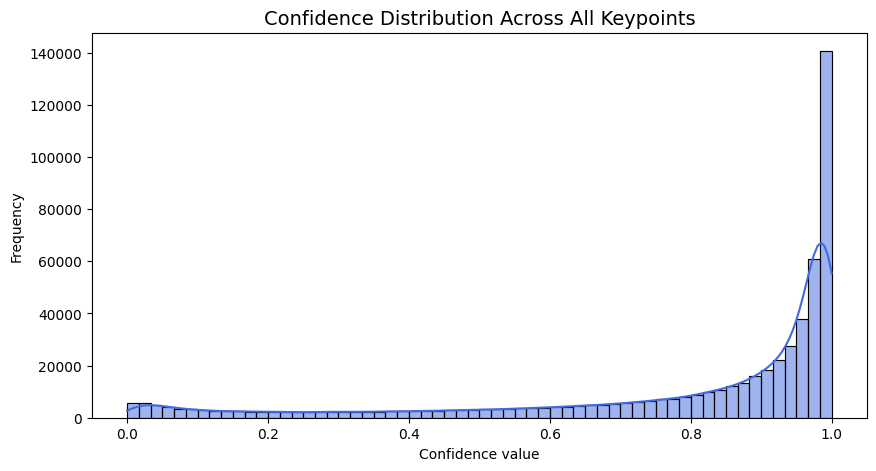

/tmp/ipython-input-2397661123.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=conf_data, x="Keypoint", y="Confidence", palette="coolwarm")


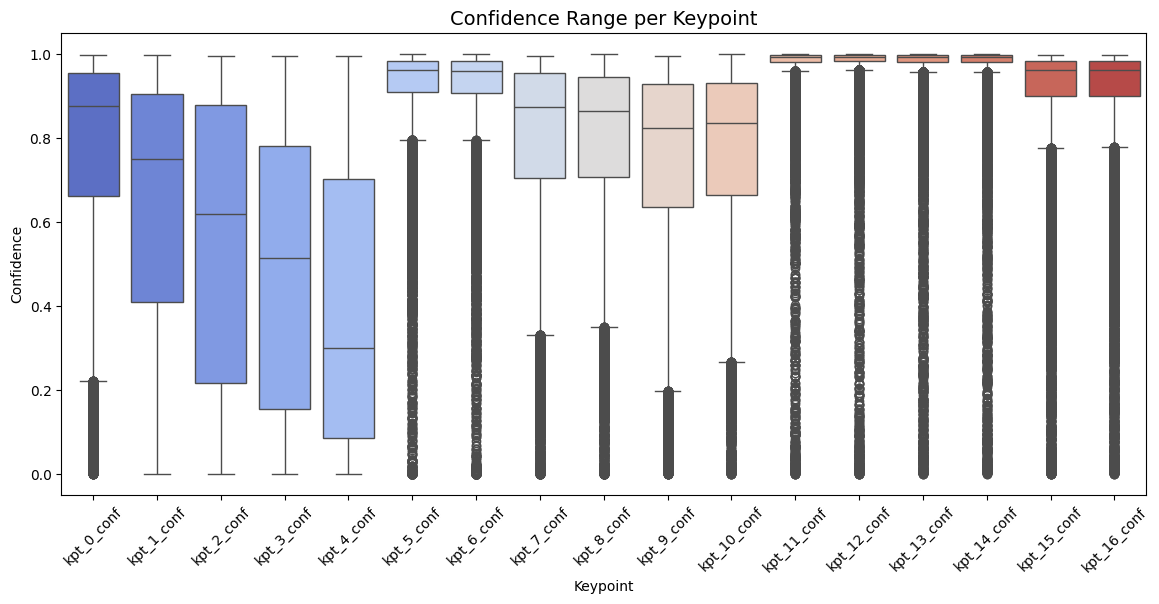

<Figure size 1000x500 with 0 Axes>

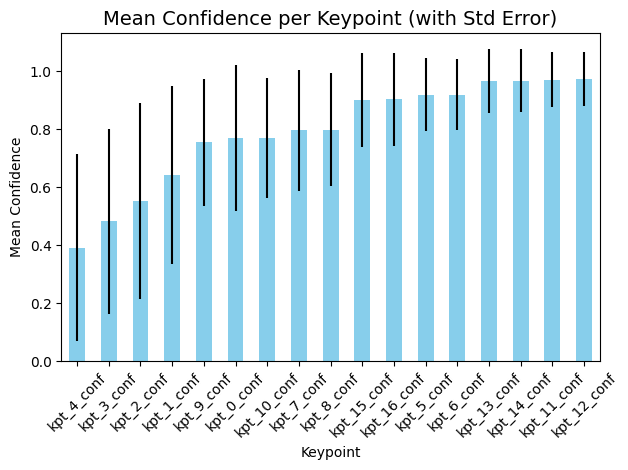

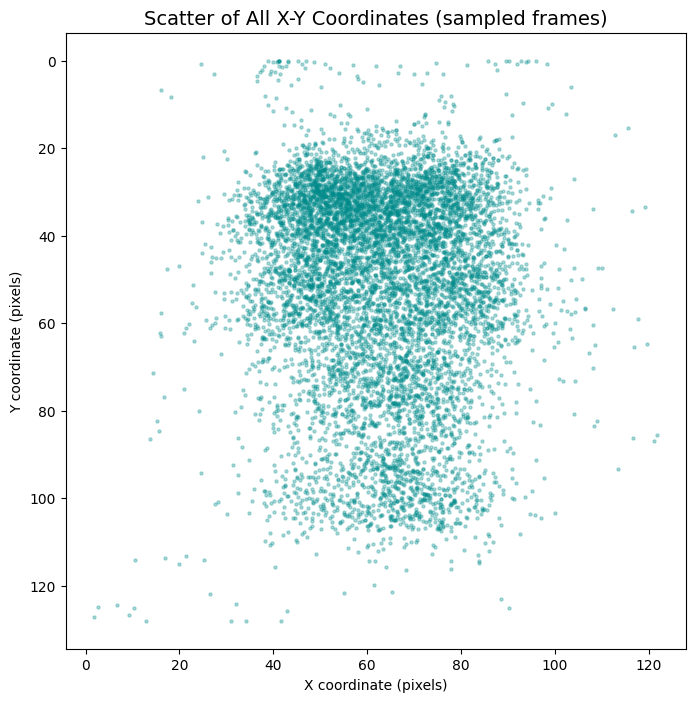

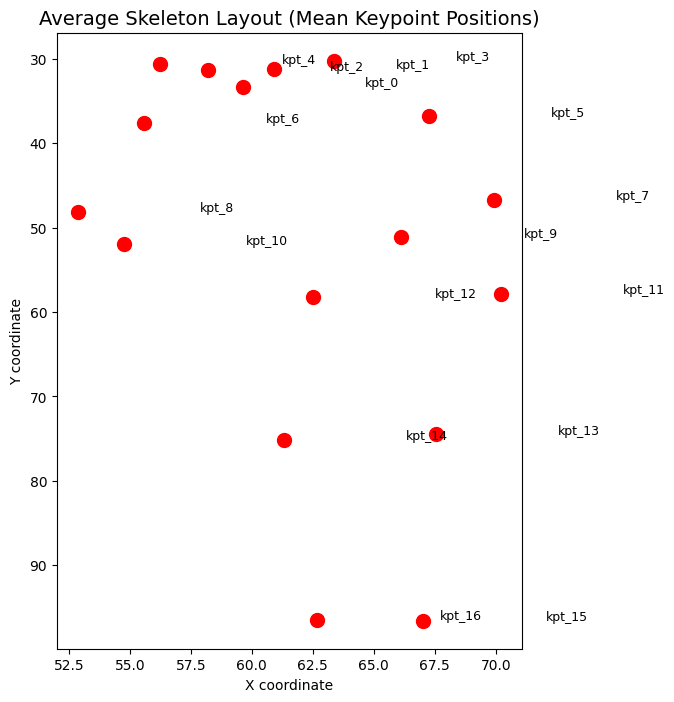

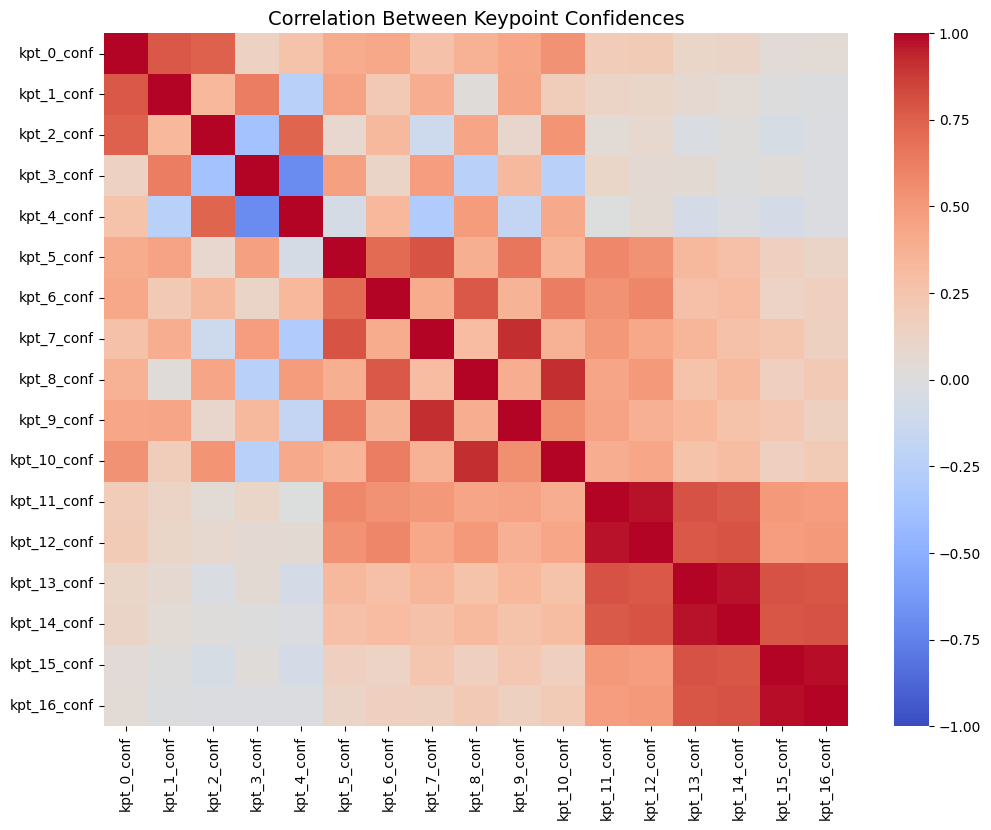

<Figure size 1000x600 with 0 Axes>

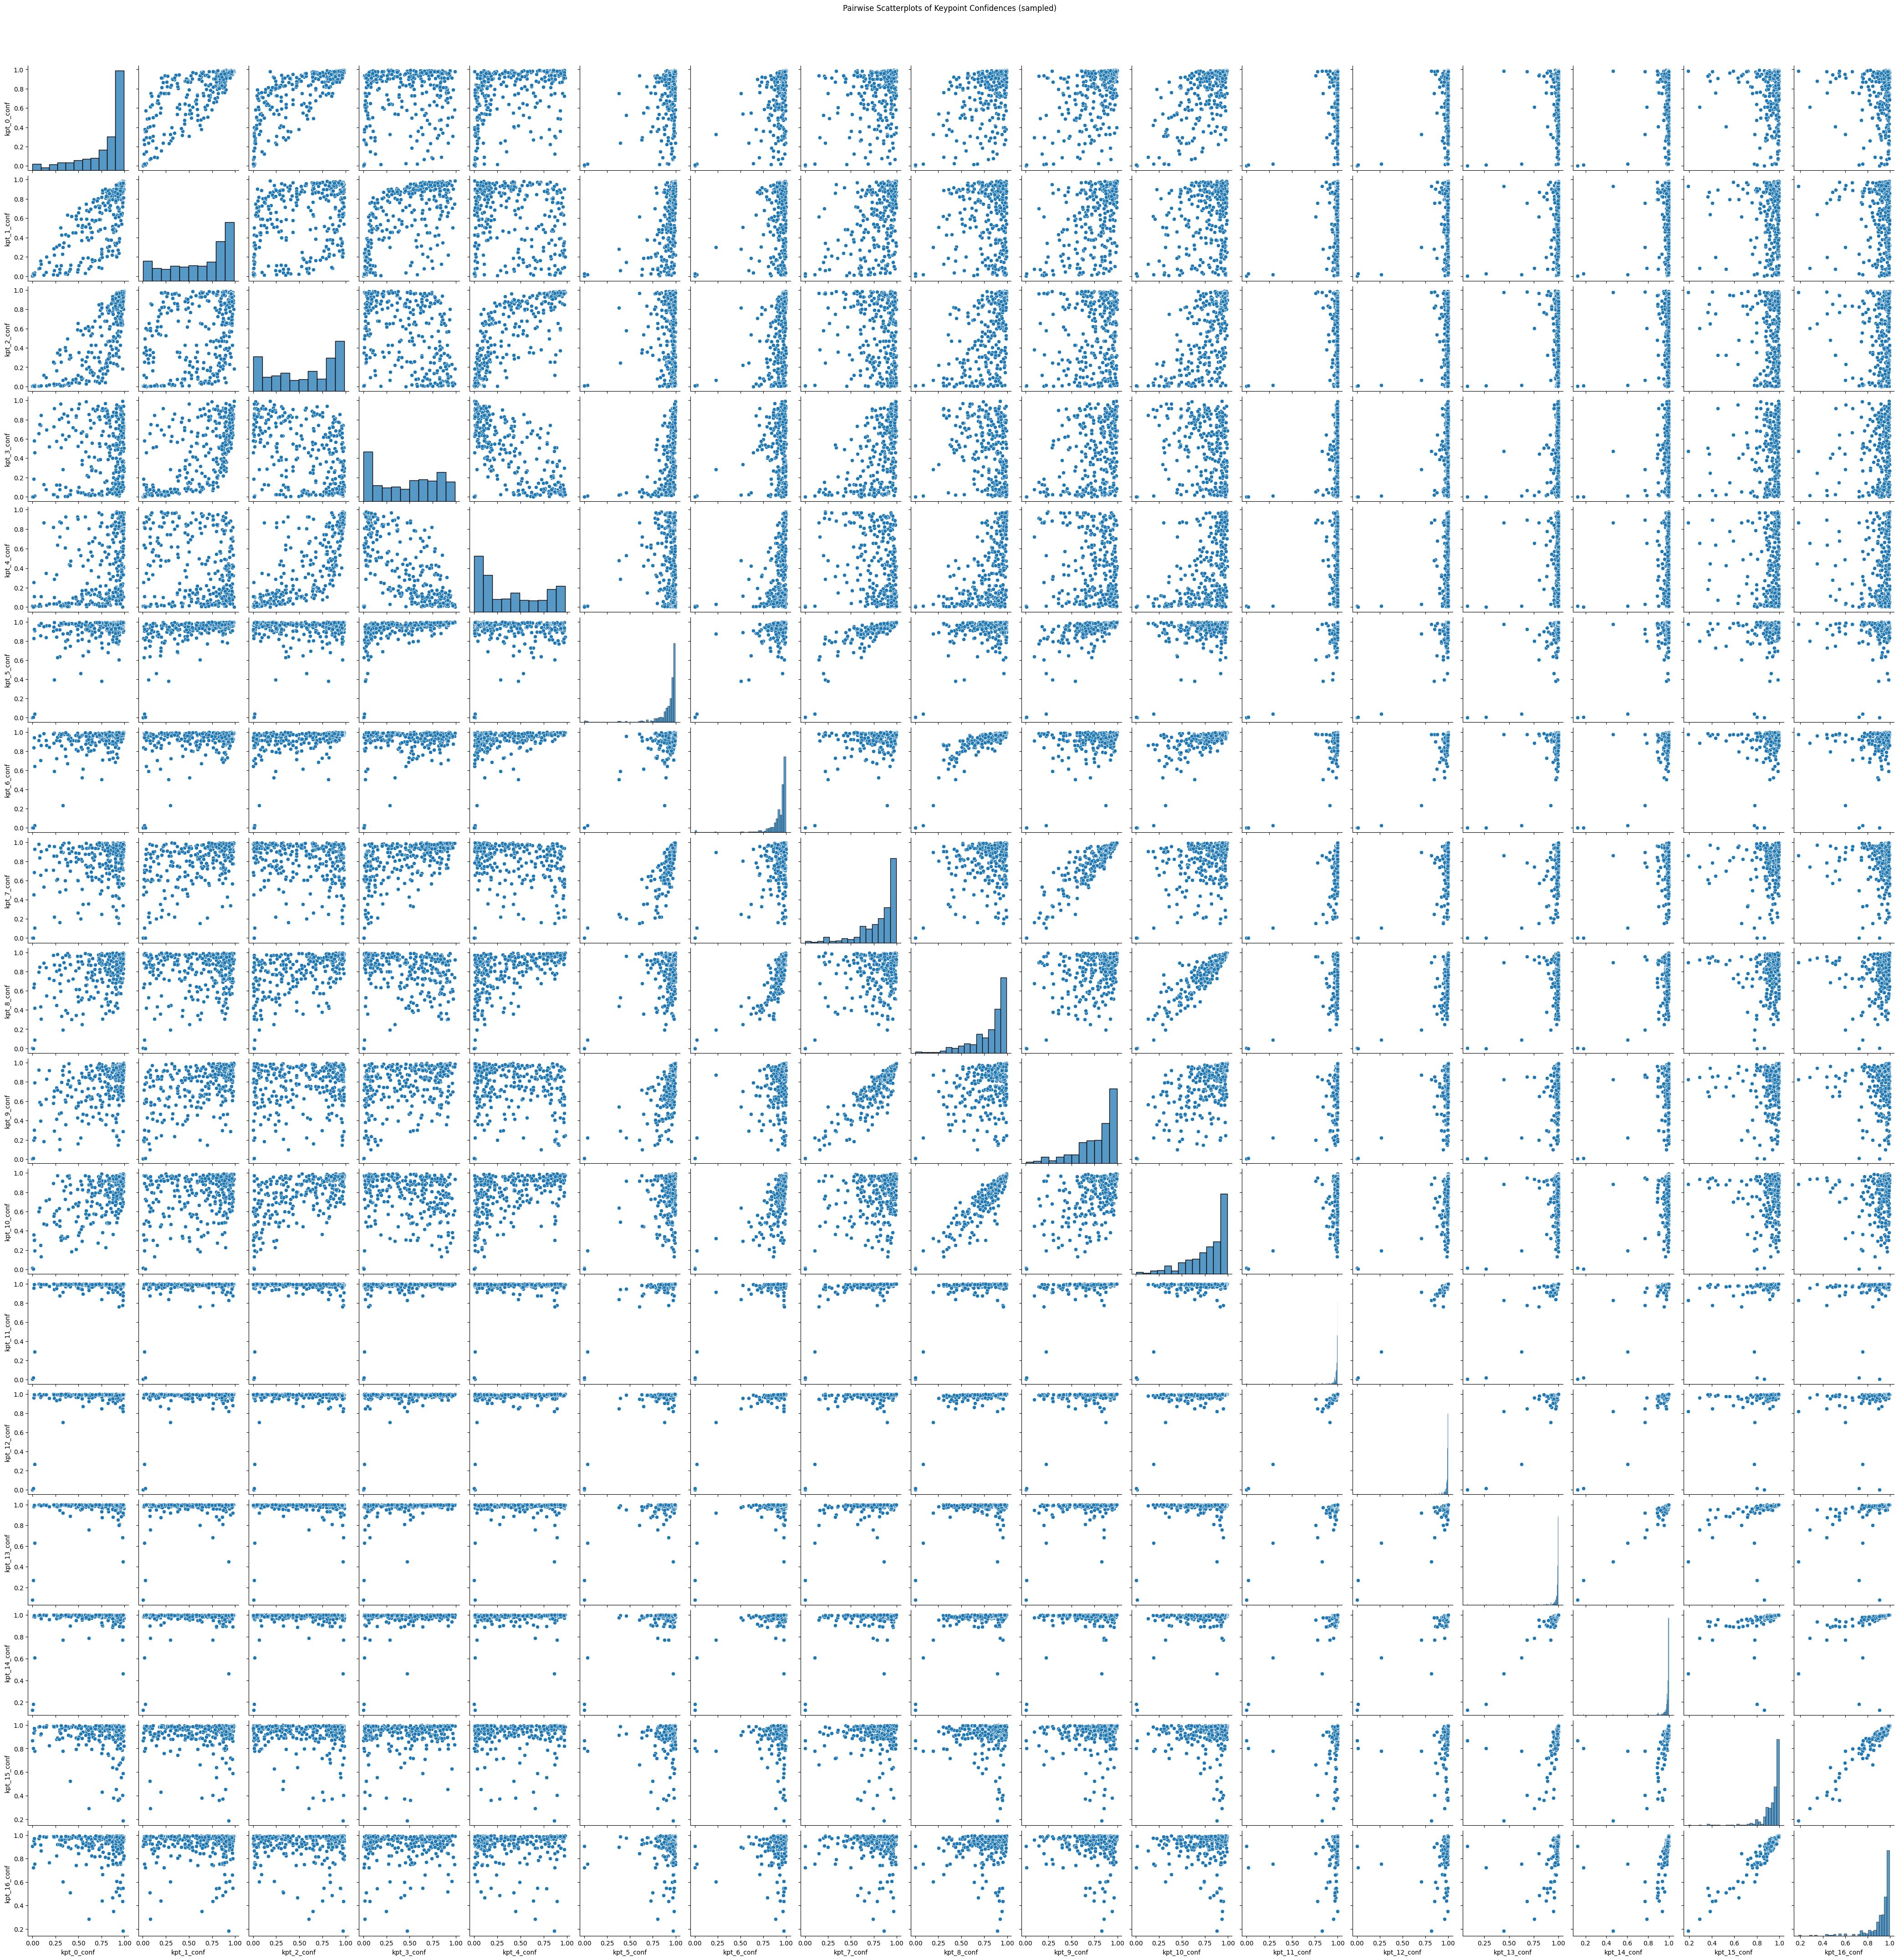

/tmp/ipython-input-2397661123.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[x_cols].melt(var_name="Keypoint", value_name="X"), x="Keypoint", y="X", ax=axes[0], palette="crest")
/tmp/ipython-input-2397661123.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[y_cols].melt(var_name="Keypoint", value_name="Y"), x="Keypoint", y="Y", ax=axes[1], palette="flare")


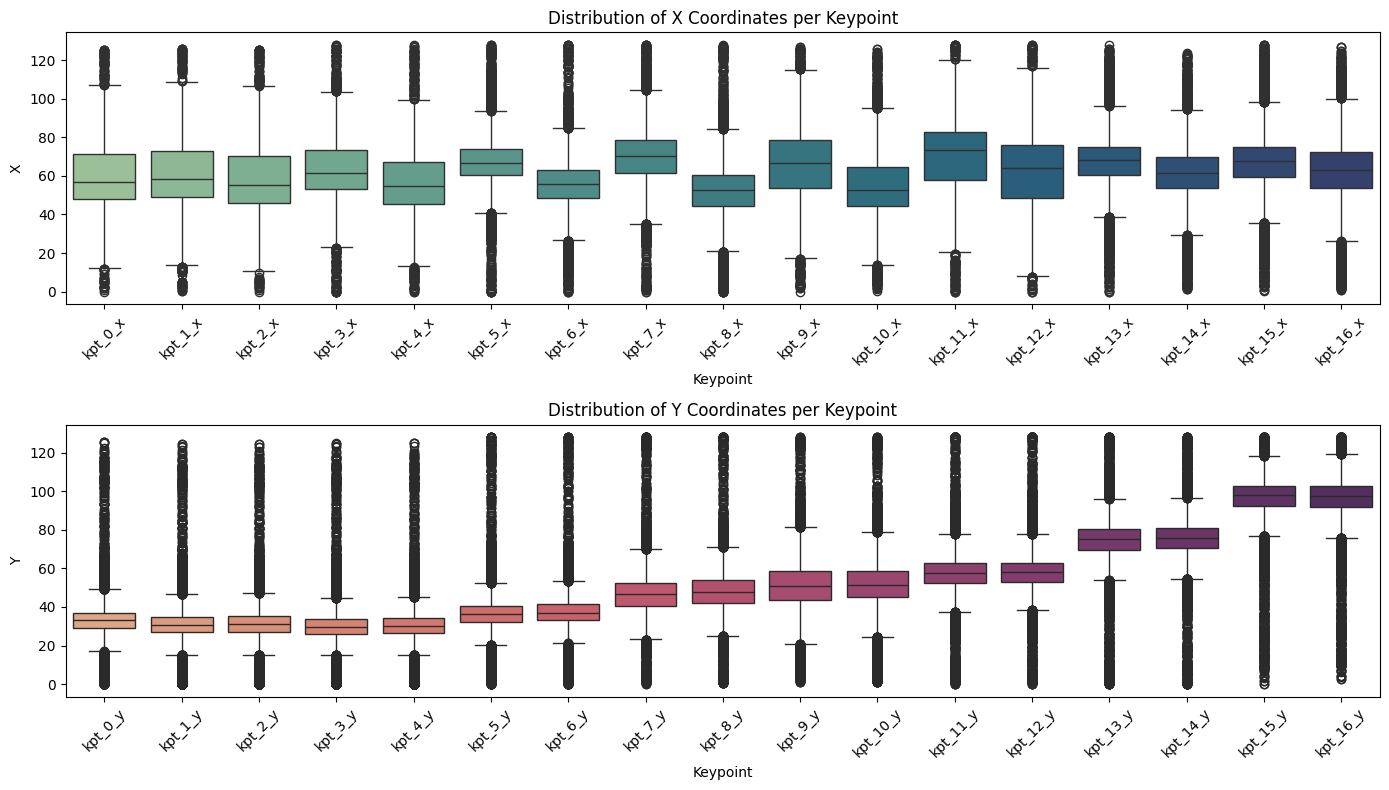

/tmp/ipython-input-2397661123.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_ratio.index, y=outlier_ratio.values, palette="mako")


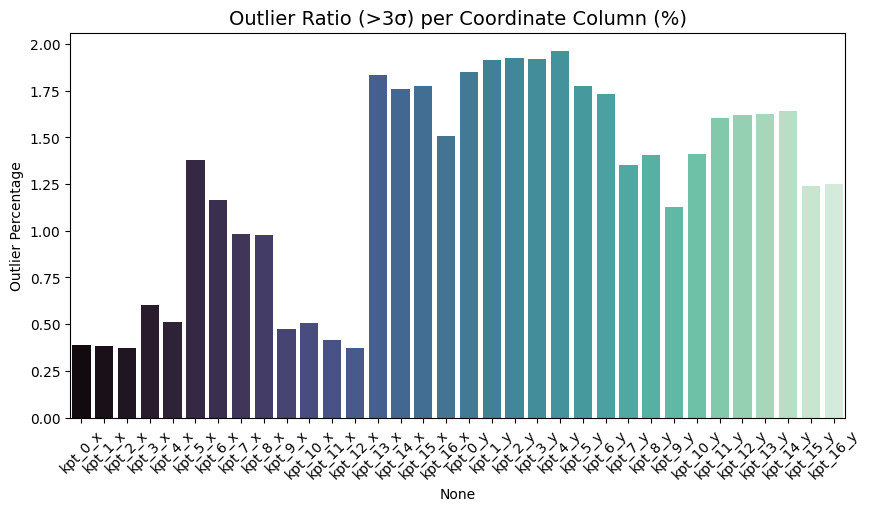

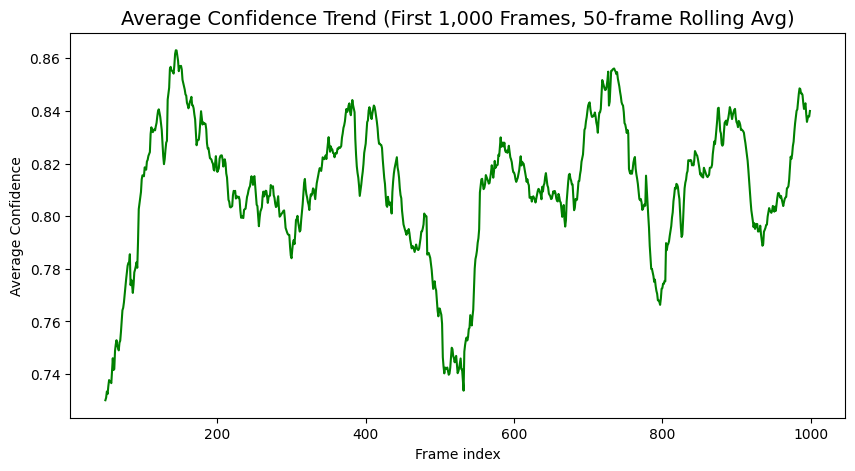

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load dataset ===
csv_path = "/content/drive/MyDrive/CricVision/pose_keypoints_full.csv"
df = pd.read_csv(csv_path)
print(f"✅ Loaded {df.shape[0]:,} frames × {df.shape[1]} columns")

# === Column breakdown ===
x_cols = [c for c in df.columns if "_x" in c]
y_cols = [c for c in df.columns if "_y" in c]
conf_cols = [c for c in df.columns if "_conf" in c]

# === 1. Confidence distribution across all joints ===
plt.figure(figsize=(10,5))
sns.histplot(df[conf_cols].melt()["value"], bins=60, kde=True, color="royalblue")
plt.title("Confidence Distribution Across All Keypoints", fontsize=14)
plt.xlabel("Confidence value")
plt.ylabel("Frequency")
plt.show()

# === 2. Boxplot per keypoint confidence ===
plt.figure(figsize=(14,6))
conf_data = df[conf_cols].melt(var_name="Keypoint", value_name="Confidence")
sns.boxplot(data=conf_data, x="Keypoint", y="Confidence", palette="coolwarm")
plt.title("Confidence Range per Keypoint", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# === 3. Mean & std confidence per keypoint ===
conf_summary = df[conf_cols].agg(["mean", "std"]).T
plt.figure(figsize=(10,5))
conf_summary.sort_values("mean", inplace=False).plot(kind="bar", y="mean", yerr="std", legend=False, color="skyblue")
plt.title("Mean Confidence per Keypoint (with Std Error)", fontsize=14)
plt.xlabel("Keypoint")
plt.ylabel("Mean Confidence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. Scatter sample of X vs Y positions ===
sample = df.sample(500, random_state=42)
plt.figure(figsize=(8,8))
plt.scatter(sample[x_cols].values.flatten(), sample[y_cols].values.flatten(),
            alpha=0.3, s=5, color="darkcyan")
plt.gca().invert_yaxis()
plt.title("Scatter of All X-Y Coordinates (sampled frames)", fontsize=14)
plt.xlabel("X coordinate (pixels)")
plt.ylabel("Y coordinate (pixels)")
plt.show()

# === 5. Keypoint spatial spread heatmap (density of coordinates) ===
# We'll visualize the average body skeleton structure (mean X/Y per keypoint)
mean_x = df[x_cols].mean()
mean_y = df[y_cols].mean()

plt.figure(figsize=(6,8))
plt.scatter(mean_x, mean_y, s=100, c="red")
for i, (x, y) in enumerate(zip(mean_x, mean_y)):
    plt.text(x+5, y, f"kpt_{i}", fontsize=9)
plt.gca().invert_yaxis()
plt.title("Average Skeleton Layout (Mean Keypoint Positions)", fontsize=14)
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

# === 6. Correlation heatmap for keypoint confidences ===
plt.figure(figsize=(12,9))
corr = df[conf_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Between Keypoint Confidences", fontsize=14)
plt.show()

# === 7. Pairwise scatter of confidences (sample) ===
plt.figure(figsize=(10,6))
sns.pairplot(df[conf_cols].sample(300, random_state=42))
plt.suptitle("Pairwise Scatterplots of Keypoint Confidences (sampled)", y=1.02)
plt.show()

# === 8. Coordinate range per keypoint (boxplots) ===
fig, axes = plt.subplots(2, 1, figsize=(14,8))
sns.boxplot(data=df[x_cols].melt(var_name="Keypoint", value_name="X"), x="Keypoint", y="X", ax=axes[0], palette="crest")
sns.boxplot(data=df[y_cols].melt(var_name="Keypoint", value_name="Y"), x="Keypoint", y="Y", ax=axes[1], palette="flare")
axes[0].set_title("Distribution of X Coordinates per Keypoint")
axes[1].set_title("Distribution of Y Coordinates per Keypoint")
for ax in axes:
    ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

# === 9. Outlier detection on coordinate space ===
coord_cols = x_cols + y_cols
coord_stats = df[coord_cols].describe().T
z_scores = np.abs((df[coord_cols] - df[coord_cols].mean()) / df[coord_cols].std())
outlier_ratio = (z_scores > 3).mean() * 100
plt.figure(figsize=(10,5))
sns.barplot(x=outlier_ratio.index, y=outlier_ratio.values, palette="mako")
plt.title("Outlier Ratio (>3σ) per Coordinate Column (%)", fontsize=14)
plt.ylabel("Outlier Percentage")
plt.xticks(rotation=45)
plt.show()

# === 10. Confidence trends across frames (first 1,000 frames) ===
conf_mean_by_frame = df[conf_cols].mean(axis=1).rolling(window=50).mean().iloc[:1000]
plt.figure(figsize=(10,5))
plt.plot(conf_mean_by_frame, color="green")
plt.title("Average Confidence Trend (First 1,000 Frames, 50-frame Rolling Avg)", fontsize=14)
plt.xlabel("Frame index")
plt.ylabel("Average Confidence")
plt.show()
